In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [4]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [10]:
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [11]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

In [13]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 11ms/step - loss: 195.5726 - mae: 196.0726 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 194.7819 - mae: 195.2819 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 193.5109 - mae: 194.0109 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 191.9080 - mae: 192.4080 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 190.0235 - mae: 190.5235 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 187.8582 - mae: 188.3582 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 185.3786 - mae: 185.8786 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 182.5483 - mae: 183.0483 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 179.3126 - mae: 179.8126

8/8 [==============================] - 0s 7ms/step - loss: 9.5518 - mae: 10.0439 - lr: 4.4668e-05
Epoch 75/100
8/8 [==============================] - 0s 6ms/step - loss: 7.9709 - mae: 8.4576 - lr: 5.0119e-05
Epoch 76/100
8/8 [==============================] - 0s 7ms/step - loss: 7.5876 - mae: 8.0740 - lr: 5.6234e-05
Epoch 77/100
8/8 [==============================] - 0s 7ms/step - loss: 8.6594 - mae: 9.1468 - lr: 6.3096e-05
Epoch 78/100
8/8 [==============================] - 0s 6ms/step - loss: 10.9943 - mae: 11.4885 - lr: 7.0795e-05
Epoch 79/100
8/8 [==============================] - 0s 7ms/step - loss: 8.4378 - mae: 8.9243 - lr: 7.9433e-05
Epoch 80/100
8/8 [==============================] - 0s 7ms/step - loss: 13.3352 - mae: 13.8254 - lr: 8.9125e-05
Epoch 81/100
8/8 [==============================] - 0s 6ms/step - loss: 8.6512 - mae: 9.1402 - lr: 1.0000e-04
Epoch 82/100
8/8 [==============================] - 0s 7ms/step - loss: 15.4092 - mae: 15.8985 - lr: 1.1220e-04
Epoch 83/100
8/8

(1e-08, 0.0001, 0.0, 30.0)

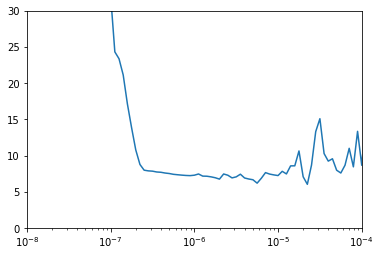

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [17]:
dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [18]:
optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)

In [19]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [20]:
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 9ms/step - loss: 48.8423 - mae: 49.3398
Epoch 2/400
8/8 [==============================] - 0s 7ms/step - loss: 25.4184 - mae: 25.9168
Epoch 3/400
8/8 [==============================] - 0s 9ms/step - loss: 19.0810 - mae: 19.5760
Epoch 4/400
8/8 [==============================] - 0s 7ms/step - loss: 15.9127 - mae: 16.4082
Epoch 5/400
8/8 [==============================] - 0s 7ms/step - loss: 14.2854 - mae: 14.7747
Epoch 6/400
8/8 [==============================] - 0s 7ms/step - loss: 12.0783 - mae: 12.5695
Epoch 7/400
8/8 [==============================] - 0s 7ms/step - loss: 9.9839 - mae: 10.4685
Epoch 8/400
8/8 [==============================] - 0s 7ms/step - loss: 8.7568 - mae: 9.2456
Epoch 9/400
8/8 [==============================] - 0s 7ms/step - loss: 10.1072 - mae: 10.5991
Epoch 10/400
8/8 [==============================] - 0s 7ms/step - loss: 9.9202 - mae: 10.4078
Epoch 11/400
8/8 [==============================] - 0s 7ms/step

8/8 [==============================] - 0s 6ms/step - loss: 4.7302 - mae: 5.2081
Epoch 90/400
8/8 [==============================] - 0s 6ms/step - loss: 4.7346 - mae: 5.2147
Epoch 91/400
8/8 [==============================] - 0s 6ms/step - loss: 5.6920 - mae: 6.1733
Epoch 92/400
8/8 [==============================] - 0s 6ms/step - loss: 5.0414 - mae: 5.5186
Epoch 93/400
8/8 [==============================] - 0s 6ms/step - loss: 4.9401 - mae: 5.4165
Epoch 94/400
8/8 [==============================] - 0s 6ms/step - loss: 4.7784 - mae: 5.2531
Epoch 95/400
8/8 [==============================] - 0s 6ms/step - loss: 4.8355 - mae: 5.3088
Epoch 96/400
8/8 [==============================] - 0s 6ms/step - loss: 6.0727 - mae: 6.5588
Epoch 97/400
8/8 [==============================] - 0s 8ms/step - loss: 6.3211 - mae: 6.8037
Epoch 98/400
8/8 [==============================] - 0s 6ms/step - loss: 6.1974 - mae: 6.6813
Epoch 99/400
8/8 [==============================] - 0s 6ms/step - loss: 5.5559 - ma

8/8 [==============================] - 0s 6ms/step - loss: 5.5953 - mae: 6.0794
Epoch 177/400
8/8 [==============================] - 0s 6ms/step - loss: 5.5889 - mae: 6.0702
Epoch 178/400
8/8 [==============================] - 0s 6ms/step - loss: 5.7092 - mae: 6.1903
Epoch 179/400
8/8 [==============================] - 0s 6ms/step - loss: 4.9521 - mae: 5.4319
Epoch 180/400
8/8 [==============================] - 0s 6ms/step - loss: 4.4569 - mae: 4.9316
Epoch 181/400
8/8 [==============================] - 0s 6ms/step - loss: 4.5190 - mae: 4.9968
Epoch 182/400
8/8 [==============================] - 0s 6ms/step - loss: 4.5418 - mae: 5.0144
Epoch 183/400
8/8 [==============================] - 0s 6ms/step - loss: 4.5716 - mae: 5.0488
Epoch 184/400
8/8 [==============================] - 0s 6ms/step - loss: 4.9955 - mae: 5.4729
Epoch 185/400
8/8 [==============================] - 0s 6ms/step - loss: 5.1940 - mae: 5.6752
Epoch 186/400
8/8 [==============================] - 0s 8ms/step - loss: 4

8/8 [==============================] - 0s 6ms/step - loss: 4.6604 - mae: 5.1372
Epoch 264/400
8/8 [==============================] - 0s 6ms/step - loss: 4.5179 - mae: 4.9928
Epoch 265/400
8/8 [==============================] - 0s 6ms/step - loss: 4.6715 - mae: 5.1510
Epoch 266/400
8/8 [==============================] - 0s 6ms/step - loss: 4.3393 - mae: 4.8133
Epoch 267/400
8/8 [==============================] - 0s 6ms/step - loss: 4.1408 - mae: 4.6142
Epoch 268/400
8/8 [==============================] - 0s 6ms/step - loss: 4.4039 - mae: 4.8805
Epoch 269/400
8/8 [==============================] - 0s 6ms/step - loss: 4.2207 - mae: 4.6914
Epoch 270/400
8/8 [==============================] - 0s 8ms/step - loss: 4.2784 - mae: 4.7513
Epoch 271/400
8/8 [==============================] - 0s 7ms/step - loss: 4.3592 - mae: 4.8380
Epoch 272/400
8/8 [==============================] - 0s 6ms/step - loss: 5.5202 - mae: 6.0007
Epoch 273/400
8/8 [==============================] - 0s 9ms/step - loss: 5

8/8 [==============================] - 0s 7ms/step - loss: 4.4646 - mae: 4.9392
Epoch 351/400
8/8 [==============================] - 0s 7ms/step - loss: 4.1852 - mae: 4.6549
Epoch 352/400
8/8 [==============================] - 0s 6ms/step - loss: 4.1903 - mae: 4.6650
Epoch 353/400
8/8 [==============================] - 0s 6ms/step - loss: 4.3855 - mae: 4.8576
Epoch 354/400
8/8 [==============================] - 0s 6ms/step - loss: 4.6306 - mae: 5.1051
Epoch 355/400
8/8 [==============================] - 0s 7ms/step - loss: 5.6045 - mae: 6.0878
Epoch 356/400
8/8 [==============================] - 0s 6ms/step - loss: 5.3000 - mae: 5.7858
Epoch 357/400
8/8 [==============================] - 0s 7ms/step - loss: 4.9870 - mae: 5.4592
Epoch 358/400
8/8 [==============================] - 0s 8ms/step - loss: 4.7477 - mae: 5.2230
Epoch 359/400
8/8 [==============================] - 0s 7ms/step - loss: 4.4564 - mae: 4.9328
Epoch 360/400
8/8 [==============================] - 0s 8ms/step - loss: 4

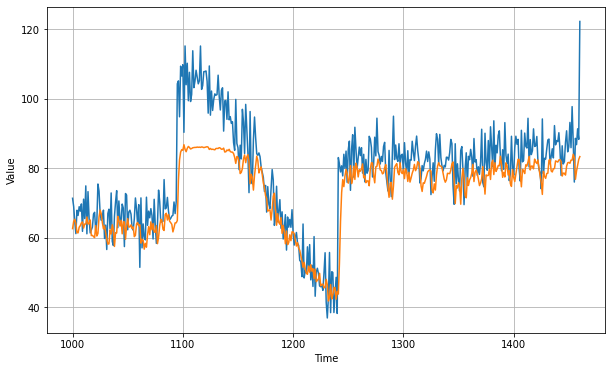

In [21]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

7.12318

<Figure size 432x288 with 0 Axes>

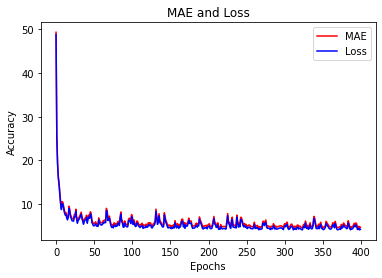

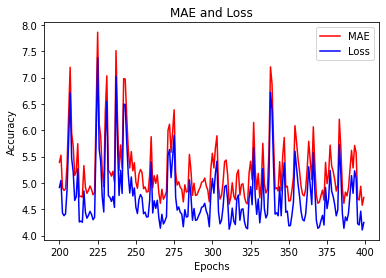

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()